In [1]:
"https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0"
"https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import gensim
from tqdm import tqdm
from nltk.corpus import stopwords
from gensim.models import LdaModel

plt.style.use('seaborn')

#data_path = "data/santiago_covid_2020.csv"
#data_path = "data/santiago_enero.csv"
data_path = "data/gabrielboric.csv"



# spanish stop words
stop_words = set(stopwords.words('spanish'))
stop_words = ['t', 'si', 'q', 'https', 'co', 'solo', 'ser', 'bien', 
            'así', 'ma', 'mas', 'igual', 'va', 'después',
            'hacer', 'hace', 'creo'] + list(stop_words)

C:\Users\jigna\AppData\Local\Programs\Python\Python36\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# **Métodos útiles**

In [6]:
def bar_plot(x, y, title, file_name):
    """useful method to generate and save bar plots.

    Args:
        x (str, float?): names.
        y (float): value of each name.
        title (str): title to put on the plot.
        file_name (str): fiel name to save the plot
    """
    plt.bar(x, y)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.savefig("imgs/segunda_avance/" + file_name)
    plt.show()

def delete_chars(text, unwanted_chars):
    """
    useful method to replace a list of chars on text.
    return:
        (str) the same str without the chars in chars.
    """
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

def preprocess_tweet(tweet):
    """
    Replaces unwanted characters and performs
    a preprocessing.
    input: 
        (str) tweet.
    return:
        (str[]) final: list of words.
    """
    unwanted = ['#', ',', '.', '!', '?', '¿', '¡', '(',\
                ')', '-', '=', 'jaja', 'jajaja']
    final = delete_chars(tweet, unwanted).split()
    final = [w.lower() for w in final]
    # Asumo que no hay @´s de dos caracteres como @ho.
    final = [w for w in final if w not in stop_words and len(w) > 3]
    # Se eliminan links
    final = [w for w in final if w[:4] != 'http']
    #final = [w for w in final if w[:1] != '@']
    return final

def bar_plot_boric(top_topics):
    """Plots the distribution for each topic.

    Args:
        top_topics ([type]): From lda_model.
    """
    # Correr sólo para generar y guardar plots.
    for ind, t in enumerate(top_topics):
        bar_plot([x[1] for x in t[0]], [x[0] for x in t[0]], \
                "Probabilidades por palabra: tópico {}. \n coherencia: {}".format(ind, round(t[1],2)), \
                "boric_barplot{}.png".format(ind))

def preprocessed_tweets(data_path):
    """Preprocess for twitter data.

    Args:
        data_path (str): path to raw twitter data csv. Must have ['date', 'tweet'] columns.

    Returns:
        pd.DataFrame: preprocessed twitter data.
    """
    # Read and preprocecss data. El orden de los procesos importa.
    data = pd.read_csv(data_path)[['date', 'tweet']]
    data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data['date']]
    processed_tweets = data['tweet'].map(preprocess_tweet)
    dropers = []
    for ind, tweet in enumerate(processed_tweets):
        if len(tweet) < 5:
            dropers.append(ind) 
    return processed_tweets.drop(dropers) 
    
# mini mini test
print(preprocess_tweet('##hola) ¿chao? =) jaja! @jaja_ja'))


['hola', 'chao', '@_ja']


# **Tweets**: Estadísticas del Corpus.

In [3]:
# Raw data, no pre-process yet. Index no puede ser las fechas porque se repiten.
# 3756 días.

data = pd.read_csv(data_path)[['date', 'tweet']]
data.head(10)
print('---------------------------------------------------------')
print('Sample: ', data.iloc[0]['tweet'])
print('---------------------------------------------------------')
print('Cantidad de tweets basal: ', len(data))
print('---------------------------------------------------------')
print('Sample: ')
# Manejamos el formato de las fechas en data. Correr sólo una vez esta celda.
data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data['date']]

#data.drop('date', axis=1, inplace=True)
data[data['date'] == '2015-10-20']

C:\Users\jigna\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


---------------------------------------------------------
Sample:  Hoy nos reunimos con el Rector de la @uvalpochile @ocorralesj para conversar sobre educación superior y los desafíos de las universidades estatales para el nuevo Chile. Nuestro gobierno buscará fortalecer la #educación pública de calidad.  https://t.co/aXvXMWoNPx
---------------------------------------------------------
Cantidad de tweets basal:  39405
---------------------------------------------------------
Sample: 


,date,tweet
15062,2015-10-20,@Francrovetto mal.
15063,2015-10-20,@GiSilore 🙋
15064,2015-10-20,@IsReal1948 impactante
15065,2015-10-20,:)
15066,2015-10-20,@depelox no estoy de acuerdo.
...,...,...
15188,2015-10-20,@AlejandraOliden https://t.co/VpAt7VsrgW
15189,2015-10-20,@Bienvenidos13 @canal13 aquí estamo' 🙋
15190,2015-10-20,@CRISPORTS10 https://t.co/VpAt7VsrgW
15191,2015-10-20,@cata__eme peras mentiras socia ;) https://t....


In [9]:
# Group by day. Se rellenan las fechas faltantes (de haber).

# Creamos el full index.
full_index = pd.date_range(data['date'].min(), data['date'].max())
# Creamos la serie con el número de tweets diarios y le ponemos como index las fechas.
by_day = data.groupby(['date']).count()
by_day.index = set(data['date'])
print('Largo antes del reindex: ', len(by_day))
# reindex.
by_day = by_day.reindex(full_index, fill_value=0)
print('Largo después del reindex: ', len(by_day))



print('----------------------------------------------------------------')
print('Agrupación de tweets por día: ')
print('Mean = {}'.format(by_day.mean().to_string(index=False)))
print('Min = {}'.format(by_day.min().to_string(index=False)))
print('Max = {}'.format(by_day.max().to_string(index=False)))
print('----------------------------------------------------------------')


# Fecha del máximo diario.
by_day[by_day['tweet'] == 131]

Largo antes del reindex:  3756
Largo después del reindex:  4308
----------------------------------------------------------------
Agrupación de tweets por día: 
Mean =  9.146936
Min =  0
Max =  131
----------------------------------------------------------------


,tweet
2018-04-04,131


In [150]:
# Agrupación cada 7 días.
seven_days = by_day.resample('W').sum()


print('----------------------------------------------------------------')
print('Agrupación de tweets cada 7 días: ')
print('Mean = {}'.format(seven_days.mean().to_string(index=False)))
print('Min = {}'.format(seven_days.min().to_string(index=False)))
print('Max = {}'.format(seven_days.max().to_string(index=False)))

seven_days


----------------------------------------------------------------
Agrupación de tweets cada 7 días: 
Mean =  63.969156
Min =  0
Max =  379


,tweet
2009-09-20,4
2009-09-27,2
2009-10-04,3
2009-10-11,0
2009-10-18,2
...,...
2021-06-06,76
2021-06-13,76
2021-06-20,69
2021-06-27,98


----------------------------------------------------------------
Agrupación de tweets por año: 
Mean =  3031.153846
Min =  48
Max =  6904


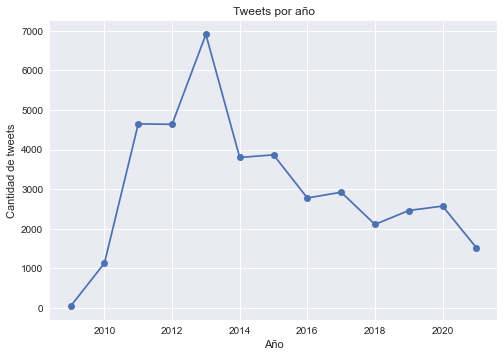

In [147]:
# Agrupación de tweets por año.

per_year = data.groupby([data.index.year]).count()
plt.plot(per_year.index, per_year['tweet'], '-o')
#for (x, y) in zip(daily.index, daily['tweet']):
#    plt.annotate('{}'.format(y), (x, y), xytext=(10,10), textcoords='offset pixels')
plt.title('Tweets por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de tweets')
#plt.savefig('imgs/boric_tweet_año.png')


print('----------------------------------------------------------------')
print('Agrupación de tweets por año: ')
print('Mean = {}'.format(per_year.mean().to_string(index=False)))
print('Min = {}'.format(per_year.min().to_string(index=False)))
print('Max = {}'.format(per_year.max().to_string(index=False)))

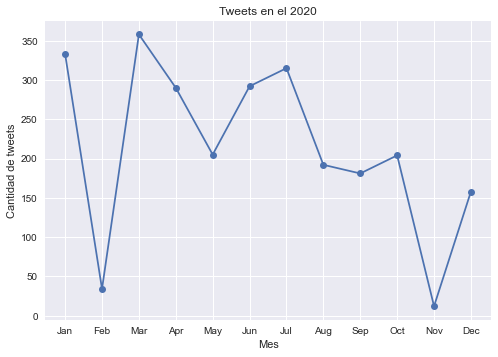

In [118]:
# Agrupación y tweets por mes.

per_month = data.groupby([data.index.year, data.index.month]).count()
only_2020 = per_month.loc[2020]

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(months, only_2020, '-o')
plt.title('Tweets en el 2020')
plt.xlabel('Mes')
plt.ylabel('Cantidad de tweets')
#plt.savefig('imgs/boric_tweet_2020.png')

In [4]:
# teting preprocess_tweet method on the first tweet.
preprocess_tweet(data.iloc[0]['tweet'])

['reunimos',
 'rector',
 '@uvalpochile',
 '@ocorralesj',
 'conversar',
 'educación',
 'superior',
 'desafíos',
 'universidades',
 'estatales',
 'nuevo',
 'chile',
 'gobierno',
 'buscará',
 'fortalecer',
 'educación',
 'pública',
 'calidad']

# **Preprocess**

In [4]:
# Se pre-procesan los tweets: Esto transforma cada
# tweet en una colección de palabras.
# processed_tweets corresponde a una lista de listas de palabras.

processed_tweets = data['tweet'].map(preprocess_tweet)
processed_tweets.head()

# Se van a eliminar tweets pequeños: con menos de 5 palabras después
# del preprocessing.
dropers = []
for ind, tweet in enumerate(processed_tweets):
    if len(tweet) < 5:
        dropers.append(ind) 

processed_tweets = processed_tweets.drop(dropers)
print(processed_tweets.sample(5))

print("-----------------------------------------------------------------")
print('Cantidad de tweets resultantes: ', len(processed_tweets))

15785    [@cami_carrascoh, @guillermog1956, @daniglesia...
13467    [apoyo, compañeros, unab, movilizan, desmercan...
34942    [sepa, senadora, desginada, baer, entiende, de...
11936    [aquí, chic@s, nobelius, ganadores, regionales...
6843     [@ale73alone, seguro, alegas, políticos, hacen...
Name: tweet, dtype: object
-----------------------------------------------------------------
Cantidad de tweets resultantes:  24218


# **Diccionario y no_belows**

In [10]:
# Se crea el vocabulario. 
# Corresponde a crear una lista con todas las palabras involucradas 
# en el corpus asignando un índice único a cada una.

dictionary = gensim.corpora.Dictionary(processed_tweets)

c = 0
for k, v in dictionary.iteritems():
    print(k,v)
    c += 1
    if c > 5: break

print("-----------------------------------------------------------------")
print('Largo del diccionario: ', len(dictionary))
print("-----------------------------------------------------------------")

0 @ocorralesj
1 @uvalpochile
2 buscará
3 calidad
4 chile
5 conversar
-----------------------------------------------------------------
Largo del diccionario:  35892
-----------------------------------------------------------------


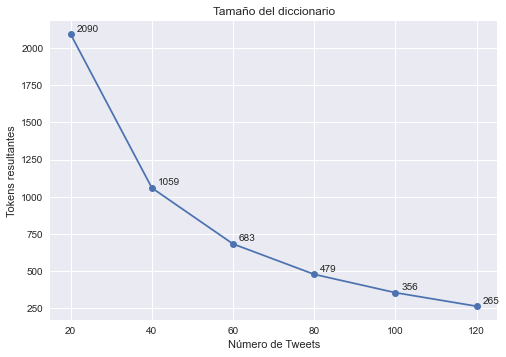

In [68]:
# Acá se filtran tokens: No se trabaja con los tweets en si sino que solamente con el vocabulario 
# que estos generan.


no_belows = [20, 40, 60, 80, 100, 120]
dict_len = [] 


for n in no_belows:
    # Se crea un dict en cada iteración.
    dictionary = gensim.corpora.Dictionary(processed_tweets)
    # Se filtra el dict.
    dictionary.filter_extremes(no_below=n, no_above=1)
    # Se guarda el len.
    dict_len.append(len(dictionary))

# Plot del largo del diccionario en función del no_below.
plt.plot(no_belows, dict_len, '-o')
for (x, y) in zip(no_belows, dict_len):
    plt.annotate('{}'.format(y), (x, y), xytext=(6,3), textcoords='offset pixels')
plt.title('Tamaño del diccionario')
plt.xlabel('Número de Tweets')
plt.ylabel('Tokens resultantes')
plt.savefig('imgs/no_below_len_dict.png')
plt.show()


In [15]:
# Se transforman las palabras a vectores con el dictionary.
# bow = "bag of words"

dictionary = gensim.corpora.Dictionary(processed_tweets)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]
i = 304
k = 666
print('bow tweet {}: \n'.format(i), bow_corpus[i])
print('bow tweet {}: \n'.format(k), bow_corpus[k])

# Con esto cada tweet se representa como una colección de tuplas (w, a) 
# donde w es el índice de la palabra y a la cantidad de apariciones en ese
# tweet.

bow tweet 304: 
 [(256, 1), (343, 1), (653, 1), (662, 1), (755, 1), (1078, 1), (1340, 1), (1457, 1), (1646, 1), (1650, 1), (1805, 1), (1862, 1), (1870, 1), (2263, 1), (2264, 1), (2295, 1), (2434, 1), (2435, 1), (2438, 1), (2454, 1), (2455, 1), (2456, 1)]
bow tweet 666: 
 [(4, 1), (10, 1), (273, 1), (445, 1), (492, 1), (733, 1), (752, 1), (769, 2), (1008, 1), (1011, 1), (1471, 1), (2274, 1), (4151, 1), (4152, 1), (4153, 1), (4154, 1)]


# **Boric0**: Primera iteración del modelo.

In [3]:
# Primera iteración del model: no se filtran palarbas y se fijan parámetros
# al ojo. El parámetro 'passes' hace que se demore en correr. 
# Basta correr la celda de los import y la de métodos útiles para que esta funcione.


"""# Read and preprocecss data. El orden de los procesos importa.
data = pd.read_csv(data_path)[['date', 'tweet']]
data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data['date']]
processed_tweets = data['tweet'].map(preprocess_tweet)
dropers = []
for ind, tweet in enumerate(processed_tweets):
    if len(tweet) < 5:
        dropers.append(ind) 
processed_tweets = processed_tweets.drop(dropers)"""

# Read and preprocecss data.
processed_tweets = preprocessed_tweets(data_path)

# Se crea el diccionario sin filtrar; modelo base.
dictionary = gensim.corpora.Dictionary(processed_tweets)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]

# Default training parameters.
num_topics = 5
chunksize = 2000
passes = 1
iterations = 50
eval_every = None 

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary#.id2token

lda_model = LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    alpha='auto',
    eta='auto',
    num_topics=5,
    random_state=1
)

top_topics = lda_model.top_topics(corpus=bow_corpus, coherence='u_mass')



# LdaMulticore


C:\Users\jigna\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (9,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
# Print de los tópicos y sus palabras.

for idx, topic in lda_model.print_topics(-1):
    print('TOPIC: {} \nWORDS: {}'.format(idx, topic))

TOPIC: 0 
WORDS: 0.008*"política" + 0.006*"chile" + 0.006*"tolerancia0" + 0.006*"movimiento" + 0.005*"mejor" + 0.005*"izquierda" + 0.005*"educación" + 0.005*"derecha" + 0.005*"columna" + 0.004*"recomiendo"
TOPIC: 1 
WORDS: 0.006*"@jparedesgodoy" + 0.005*"abrazo" + 0.005*"puede" + 0.004*"saludos" + 0.004*"@valenzuelalevi" + 0.004*"marcha" + 0.004*"alguien" + 0.004*"política" + 0.004*"quiere" + 0.004*"mismo"
TOPIC: 2 
WORDS: 0.010*"fech" + 0.009*"aguante" + 0.008*"chile" + 0.008*"universitario" + 0.007*"magallanes" + 0.007*"buena" + 0.007*"mañana" + 0.007*"estudiantil" + 0.006*"cabros" + 0.006*"@izqautonoma"
TOPIC: 3 
WORDS: 0.009*"muchas" + 0.008*"ahora" + 0.008*"@matiasdelrio" + 0.008*"vamos" + 0.008*"gracias" + 0.007*"senado" + 0.006*"concerta" + 0.005*"@saladehistoria" + 0.005*"vivo" + 0.005*"feliz"
TOPIC: 4 
WORDS: 0.011*"educación" + 0.010*"@cbellolio" + 0.008*"@valenzuelalevi" + 0.007*"casa" + 0.007*"@lboric" + 0.005*"facultad" + 0.005*"rector" + 0.005*"@donmatas" + 0.005*"arenas"

In [10]:
# Acá se generan bar plots de las probabilidades de cada palabra en los
# tópicos obtenidos.

# top_topics es un arreglo de tamaño el número de tópicos, cada elemento 
# de este arreglo es una tupla (arr, co) donde co es el valor de coherencia
# de cada tópico y arr es un arreglo de tuplas (prob, word) con la probab
# de cada palabra en el tópico. 

from pprint import pprint

top_topics = lda_model.top_topics(corpus=bow_corpus, \
                                coherence='u_mass') #texts=processed_tweets)
# Para usar ‘c_v’, ‘c_uci’ and ‘c_npmi’, texts should be provided

def bar_plot_boric(top_topics):
    """Plots the distribution for each topic.

    Args:
        top_topics ([type]): From lda_model.
    """
    # Correr sólo para generar y guardar plots.
    for ind, t in enumerate(top_topics):
        bar_plot([x[1] for x in t[0]], [x[0] for x in t[0]], \
                "Probabilidades por palabra: tópico {}. \n coherencia: {}".format(ind, round(t[1],2)), \
                "boric_barplot{}.png".format(ind))
#bar_plot_boric()


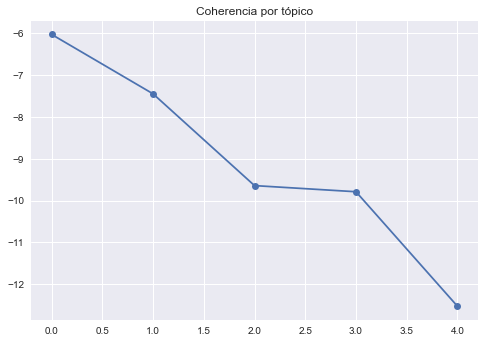

------------------------------------------------------------------------
Coherencia promedio:  -9.086522023064173
------------------------------------------------------------------------


In [11]:
# Acá graficamos la coherencia por tópico.

plt.plot(range(len(top_topics)), [t[1] for t in top_topics], 'o-')
plt.title("Coherencia por tópico")
#plt.savefig("imgs/segunda_avance/boric_topic_coherence.png")
plt.show()

print('------------------------------------------------------------------------')
print('Coherencia promedio: ', np.mean([t[1] for t in top_topics]))
print('------------------------------------------------------------------------')


 # **Optimización**: $\alpha$, $\eta$ y $\texttt{num\_topics}$.

In [8]:

def run_model(bow_corpus, dictionary, num_topics, alpha, eta):
    """Runs the model and print top topic.

    Args:
        bow_corpus ([type]): List of tweets as bow
        dictionary ([type]): dictionary form of the corpus.
        num_topics (int): number of topics.
        alpha ([float]): a-priori belief for each topic probability. 
        eta ([float, float]): a-priori belief for words probabiliry
                                on each topic.

    Returns:
        [type]: [description]
    """
    # Run model.
    lda_model = LdaModel(corpus=bow_corpus,
                        id2word=dictionary,
                        alpha=alpha,
                        eta=eta,
                        num_topics=num_topics,
                        random_state=1)
    # Get top topics from the model.
    top_topics = lda_model.top_topics(corpus=bow_corpus, coherence='u_mass')
    # Print all the important info.
    print('-------------------------------------------------------------')
    print('Dictionary len: ', len(dictionary))
    print('Amount of tweets: ', len(bow_corpus))
    print('-------------------------------------------------------------')
    for idx, topic in lda_model.print_topics(-1):
        print('TOPIC: {} \nWORDS: {}'.format(idx, topic))
    print('-------------------------------------------------------------')
    print('Average topic coherence', np.mean([t[1] for t in top_topics]))
    print('-------------------------------------------------------------')
    bar_plot_boric(top_topics)


# Method to calculate coherence measure for each hyperparamaters array.
def coherence_value(bow_corpus, dictionary, num_topics, alpha, eta):
    """Given the hyperparameters, computes a lda_model and calculates
    its 'u_mass' metric.

    Args:
        bow_corpus ([type]): List of tweets as bow
        dictionary ([type]): dictionary form of the corpus.
        num_topics (int): number of topics.
        alpha ([float]): a-priori belief for each topic probability. 
        eta ([float, float]): a-priori belief for words probabiliry
                                on each topic. 

    Returns:
        [float]: coherence measure 'u_mass'.
    """
    lda_model = LdaModel(corpus=bow_corpus,
                        id2word=dictionary,
                        alpha=alpha,
                        eta=eta,
                        num_topics=num_topics,
                        random_state=1)
    top_topics = lda_model.top_topics(corpus=bow_corpus, coherence='u_mass')
    
    return np.mean([t[1] for t in top_topics])



#mini test: 
#print(coherence_value(bow_corpus, dictionary, 5, 'auto', 'auto'))

def parameteres_optimization(topics_arr, alpha_arr, eta_arr, file_name):
    """Iterates over the array's product set, runs the model and save
    the obtained results on a csv.

    Args:
        topics_arr (int[]): number of topics.
        alpha_arr (obj[]): alpha.
        eta_arr (obj[]): eta.
        file_name (str): File name.
    """

    # Guardamos los resultados en un df que se pasará a csv.
    df_results = pd.DataFrame(columns=['parameters', 'u_mass'])
    parameters = []
    u_mass = []

    for num in tqdm(topics_arr):
        for alpha in alpha_arr:
            for eta in eta_arr:
                parameters.append((num, alpha, eta))
                u_mass.append(coherence_value(bow_corpus, dictionary, num, alpha, eta))

    df_results['parameters'] = parameters
    df_results['u_mass'] = u_mass

    # Save dataframe to csv file.
    if file_name: df_results.to_csv(file_name + '.csv')

    # Print data frame.
    print(df_results)

    # Return data frame.
    return df_results

#parameteres_optimization([5], ['auto', 0.5], ['auto', 0.5], None)

C:\Users\jigna\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (9,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 1/1 [01:41<00:00, 101.10s/it]

                   parameters    u_mass
0             (2, auto, auto) -6.346240
1        (2, auto, symmetric) -6.346240
2                (2, auto, 2) -7.409808
3                (2, auto, 3) -7.439676
4        (2, symmetric, auto) -6.363299
5   (2, symmetric, symmetric) -6.363299
6           (2, symmetric, 2) -7.405852
7           (2, symmetric, 3) -8.336858
8                (2, 2, auto) -6.070713
9           (2, 2, symmetric) -6.070713
10                  (2, 2, 2) -5.741326
11                  (2, 2, 3) -5.714602
12               (2, 3, auto) -4.789874
13          (2, 3, symmetric) -4.789874
14                  (2, 3, 2) -4.853730
15                  (2, 3, 3) -4.855455


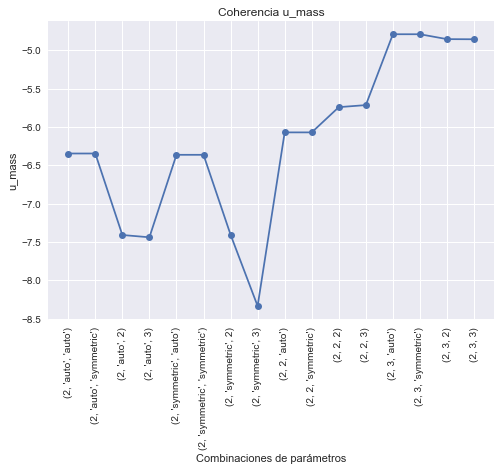

In [19]:
# Esta celda sirve para variar los arreglos, correr todo y graficar.

# id de la iteración.
i = 5
# Read and preprocess data.
processed_tweets = preprocessed_tweets(data_path)
# Se crea el diccionario sin filtrar; modelo base.
dictionary = gensim.corpora.Dictionary(processed_tweets)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]

# Arrays.
alpha_arr = ['auto', 'symmetric', 2, 3]
eta_arr = ['auto', 'symmetric', 2, 3]
file_name = 'param_optimization' + str(i) + '_informe'
df_results = parameteres_optimization([2], alpha_arr, eta_arr, file_name)

# Sacamos valores para graficar.
str_param = ['{}'.format(p) for p in df_results['parameters']]
plt.plot(str_param, df_results['u_mass'], '-o')
plt.xticks(rotation=90)
plt.title('Coherencia u_mass')
plt.ylabel('u_mass')
plt.xlabel('Combinaciones de parámetros')
plt.show()


-------------------------------------------------------------
Dictionary len:  35892
Amount of tweets:  24218
-------------------------------------------------------------
TOPIC: 0 
WORDS: 0.002*"chile" + 0.002*"política" + 0.002*"gracias" + 0.001*"ahora" + 0.001*"derecha" + 0.001*"buena" + 0.001*"abrazo" + 0.001*"educación" + 0.001*"mejor" + 0.001*"fech"
TOPIC: 1 
WORDS: 0.002*"abrazo" + 0.002*"política" + 0.001*"acuerdo" + 0.001*"chile" + 0.001*"educación" + 0.001*"ahora" + 0.001*"derecha" + 0.001*"gracias" + 0.001*"fech" + 0.001*"puede"
TOPIC: 2 
WORDS: 0.002*"chile" + 0.002*"educación" + 0.002*"izquierda" + 0.002*"gracias" + 0.001*"política" + 0.001*"abrazo" + 0.001*"mañana" + 0.001*"magallanes" + 0.001*"ahora" + 0.001*"buena"
TOPIC: 3 
WORDS: 0.002*"educación" + 0.002*"gracias" + 0.002*"ahora" + 0.002*"política" + 0.001*"muchas" + 0.001*"vamos" + 0.001*"chile" + 0.001*"mañana" + 0.001*"acuerdo" + 0.001*"estudiantes"
TOPIC: 4 
WORDS: 0.002*"educación" + 0.002*"chile" + 0.002*"ahora

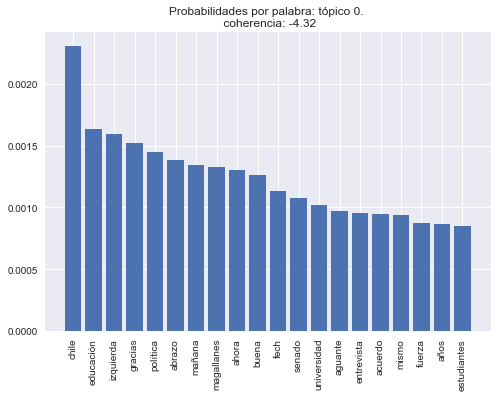

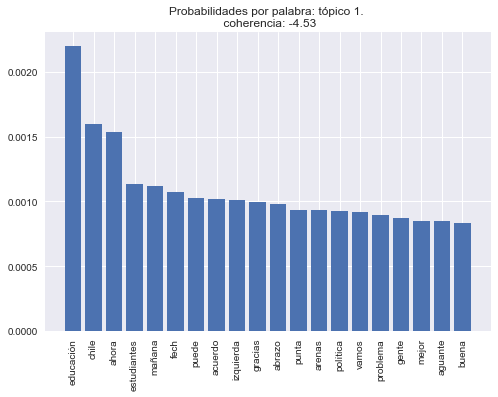

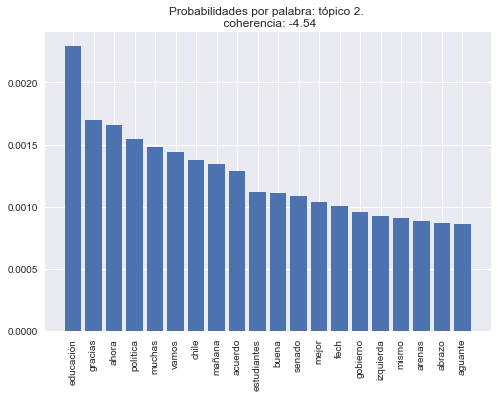

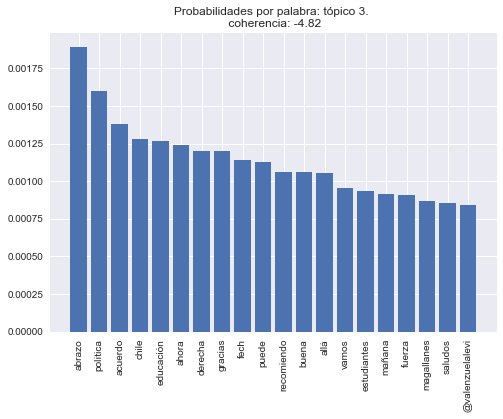

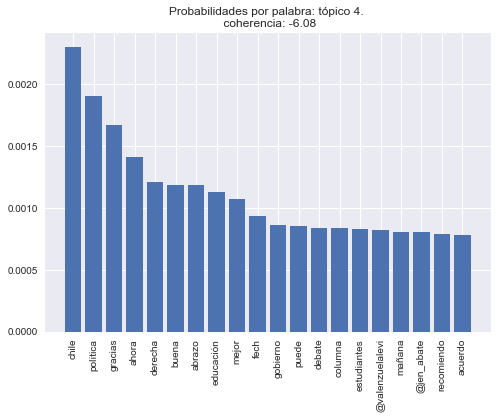

In [22]:
# Esta celda es para corre el método run_model()

# Read and preprocess data.
processed_tweets = preprocessed_tweets(data_path)
# Se crea el diccionario sin filtrar; modelo base.
dictionary = gensim.corpora.Dictionary(processed_tweets)
# dictionary.filter_extremes(no_below=n, no_above=1)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]

num_topics = 5
alpha = 2.5
eta = 2
run_model(bow_corpus, dictionary, num_topics, alpha, eta)